**FASTER RCNN**

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
import numpy as np

# Select specific classes
selected_classes = [0, 1, 2]  # Change these to desired class indices
max_images_per_class = 100

# Custom dataset class to filter specific classes and limit images
class FilteredCIFAR100(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transforms=None):
        self.cifar100 = CIFAR100(root, train=train, download=True)
        self.transforms = transforms
        self.classes = self.cifar100.classes
        
        # Filter indices
        self.filtered_indices = []
        class_counts = {cls: 0 for cls in selected_classes}
        
        for idx, (_, label) in enumerate(self.cifar100):
            if label in selected_classes and class_counts[label] < max_images_per_class:
                self.filtered_indices.append(idx)
                class_counts[label] += 1

        print(f"Selected classes: {[self.classes[i] for i in selected_classes]}")
        print(f"Total images in dataset: {len(self.filtered_indices)}")

    def __getitem__(self, idx):
        img, label = self.cifar100[self.filtered_indices[idx]]
        img = T.ToTensor()(img)
        boxes = torch.tensor([[0, 0, 32, 32]], dtype=torch.float32)
        labels = torch.tensor([label + 1], dtype=torch.int64)  # +1 for background
        target = {"boxes": boxes, "labels": labels}
        if self.transforms is not None:
            img = self.transforms(img)
        return img, target
    
    def __len__(self):
        return len(self.filtered_indices)

# Transform function
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Create filtered datasets
train_dataset = FilteredCIFAR100(root='./data', train=True, transforms=get_transform(train=True))
test_dataset = FilteredCIFAR100(root='./data', train=False, transforms=get_transform(train=False))

# DataLoader with collate function
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2)

# Model setup
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(selected_classes) + 1  # Selected classes + background
model = get_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        if (i + 1) % 10 == 0:
            print(f"Epoch {epoch}, Step {i + 1}/{len(data_loader)}, Loss: {losses.item():.4f}")
    
    avg_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch} Completed, Average Loss: {avg_loss:.4f}")

# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    torch.save(model.state_dict(), f"fasterrcnn_cifar100_filtered_epoch_{epoch+1}.pth")

100%|██████████| 169M/169M [00:02<00:00, 76.1MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Selected classes: ['apple', 'aquarium_fish', 'baby']
Total images in dataset: 300
Files already downloaded and verified
Selected classes: ['apple', 'aquarium_fish', 'baby']
Total images in dataset: 300


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 42.5MB/s] 


Epoch 0, Step 10/75, Loss: 0.1738
Epoch 0, Step 20/75, Loss: 0.1571
Epoch 0, Step 30/75, Loss: 0.1324
Epoch 0, Step 40/75, Loss: 0.1055
Epoch 0, Step 50/75, Loss: 0.0844
Epoch 0, Step 60/75, Loss: 0.0777
Epoch 0, Step 70/75, Loss: 0.0787
Epoch 0 Completed, Average Loss: 0.1468
Epoch 1, Step 10/75, Loss: 0.0706
Epoch 1, Step 20/75, Loss: 0.0516
Epoch 1, Step 30/75, Loss: 0.0531
Epoch 1, Step 40/75, Loss: 0.0594
Epoch 1, Step 50/75, Loss: 0.0599
Epoch 1, Step 60/75, Loss: 0.0587
Epoch 1, Step 70/75, Loss: 0.0447
Epoch 1 Completed, Average Loss: 0.0568


In [3]:
from torchvision.ops import box_iou

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    total_iou = 0
    total_samples = 0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"]
                gt_boxes = target["boxes"]
                
                if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                    iou = box_iou(pred_boxes, gt_boxes).mean().item()
                    total_iou += iou
                total_samples += 1
    
    avg_iou = total_iou / total_samples if total_samples > 0 else 0
    print(f"Evaluation completed. Average IoU: {avg_iou:.4f}")

# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    torch.save(model.state_dict(), f"fasterrcnn_cifar100_filtered_epoch_{epoch+1}.pth")

# Run evaluation
evaluate(model, test_loader, device)


Epoch 0, Step 10/75, Loss: 0.0440
Epoch 0, Step 20/75, Loss: 0.0526
Epoch 0, Step 30/75, Loss: 0.0519
Epoch 0, Step 40/75, Loss: 0.0472
Epoch 0, Step 50/75, Loss: 0.0393
Epoch 0, Step 60/75, Loss: 0.0502
Epoch 0, Step 70/75, Loss: 0.0404
Epoch 0 Completed, Average Loss: 0.0488
Epoch 1, Step 10/75, Loss: 0.0434
Epoch 1, Step 20/75, Loss: 0.0436
Epoch 1, Step 30/75, Loss: 0.0409
Epoch 1, Step 40/75, Loss: 0.0381
Epoch 1, Step 50/75, Loss: 0.0502
Epoch 1, Step 60/75, Loss: 0.0333
Epoch 1, Step 70/75, Loss: 0.0405
Epoch 1 Completed, Average Loss: 0.0409
Evaluation completed. Average IoU: 0.2620


<ipython-input-4-a8dc4fbdf222>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fasterrcnn_cifar100_filtered_epoch_2.pth"))


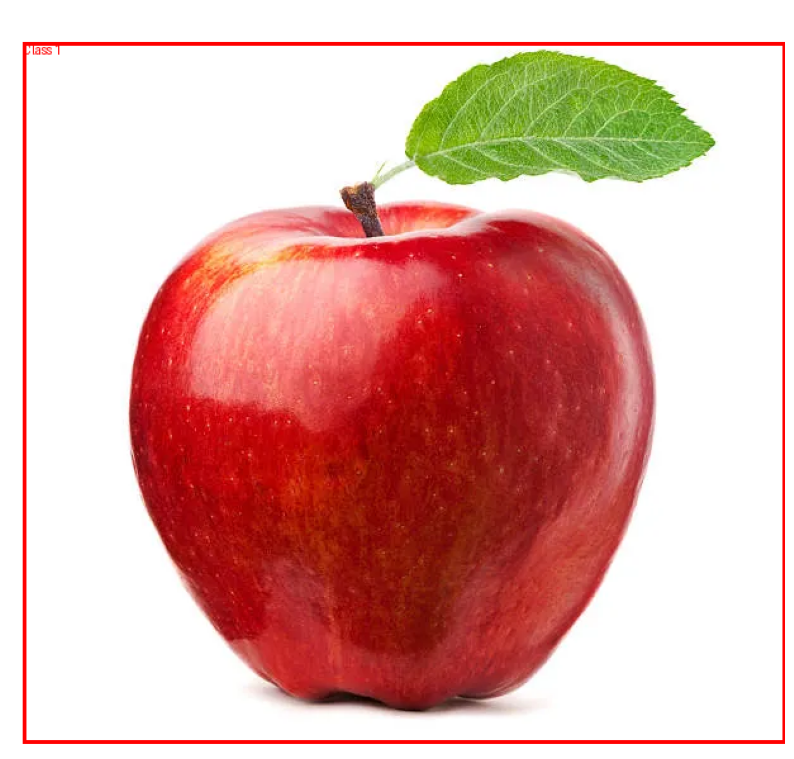

In [4]:
import torch
import torchvision
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load the trained model
model = get_model(num_classes)  # Using the same num_classes
model.load_state_dict(torch.load("fasterrcnn_cifar100_filtered_epoch_2.pth"))
model.eval()

# Ensure the model is on the same device as the input tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load an image to test (replace 'image.jpeg' with your image path)
image_path = '/kaggle/input/image-rcnn/apple.jpeg'  # Path to your test image
image = Image.open(image_path)

# Preprocess the image (resize and normalize)
transform = get_transform(train=False)
image_tensor = F.to_tensor(image).unsqueeze(0).to(device)  # Move image to the same device as the model

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)

# Extract predictions
boxes = prediction[0]['boxes'].cpu().numpy()  # Bounding boxes
labels = prediction[0]['labels'].cpu().numpy()  # Predicted labels
scores = prediction[0]['scores'].cpu().numpy()  # Confidence scores

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for i in range(len(boxes)):
    if scores[i] > 0.5:  # Only draw boxes with a confidence score above 0.5
        box = boxes[i]
        label = labels[i]
        # Convert the box coordinates to integers
        xmin, ymin, xmax, ymax = map(int, box)
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red', width=3)
        draw.text((xmin, ymin), f'Class {label}', fill='red')

# Show the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()
